# Generative Adversarial Nets

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(7).png?raw=true" width=800 height=600>

## Features

### Adversarial nets

<img src='https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_23110_(1).png?raw=true' width=600 height=150>

> * $x$ : Data
> * $p_g$ : Generator's distribution
> * $p_z(z)$ : Prior on input noise variables.
> * $G(z;\theta_g)$ : Data space where $G$ is a differentiable function represented by a multilayer perceptron with parameters $\theta_g$.
> * $D(x;\theta_d)$ : Second multilayer perceptron that outputs a single scalar.
> * $D(x)$ : Represents the probability that $x$ came from the data rather than $p_g$.
> * Train $D$ to maximize the problbility of assigning the correct label to both training examples and samples from $G$.
> * Train $G$ to minimize $log(1-D(G(z)))$.
> * $D$ and $G$ play the following two-player minimax game with value function $V(G, D)$.

<img src='https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_220110(2).png?raw=true' width=900 height=500>

* The training criterion allows one to recover the data generation distribution as $G$ and $D$ are given enough capacity, i.e., in the non-oarametric limit.
* Alternated between $k$ steps of optimizing $D$ and one step of optimizing $G$.
* After several steps of training, if $G$ and $D$ have enough capacity, they will reach a point at which both cannot improve becaues $p_g = p_{data}$.

### Theoretical  Results

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(1).png?raw=true" width=600 height=150>

> * Sample minibatch of $m$ noise samples {$z^{(1)}, z^{(2)},...,z^{(m)}$} from noise prior p_g(z).
> * Sample minibatch of $m$ examples {$z^{(1)}, z^{(2)},...,z^{(m)}$} from data generating distribution $p_{data}(x)$

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(2).png?raw=true" width=300 height=150>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(3).png?raw=true" width=600 height>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(4).png?raw=true" width=600 height=150>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(5).png?raw=true" width=600 height=150>

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/Generative%20Adversarial%20Nets/img/screenshot_230111(6).png?raw=true" width=350 height=150>

## Other Concept

### Parametric model and Non-parametric model

* Parametric model : The model has a fixed number of parameters.
    * Fast and easy to understand model.
    * Low flexibility
* Non-parametric model : The number of parameters grow with the amount of training data.
    * Flexible
    * Slow and hard to understand model.

## Practice Code

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [3]:
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

2023-01-16 10:35:25.361669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 10:35:25.366454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 10:35:25.366679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 10:35:25.367595: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

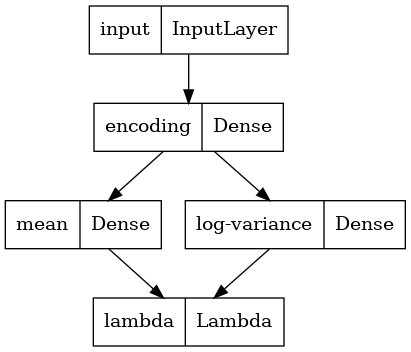

In [4]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()
plot_model(encoder)

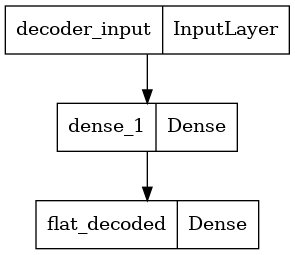

In [13]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu')(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
decoder = Model(input_decoder, x_decoded, name="decoder")
# decoder.summary()
plot_model(decoder)

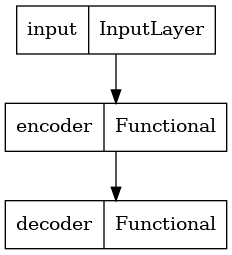

In [14]:
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
# vae.summary()
plot_model(vae)

In [7]:
kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss='binary_crossentropy')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                              

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [9]:
x_train.shape

(60000, 784)

In [10]:
vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
 78/600 [==>...........................] - ETA: 1s - loss: 0.3298

2023-01-16 10:35:27.914369: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


600/600 [==============================] - 2s 2ms/step - loss: 0.2438
Epoch 2/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2165
Epoch 3/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2123
Epoch 4/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2097
Epoch 5/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2078
Epoch 6/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2063
Epoch 7/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2049
Epoch 8/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2037
Epoch 9/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2026
Epoch 10/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2016
Epoch 11/50
600/600 [==============================] - 1s 2ms/step - loss: 0.2006
Epoch 12/50
600/600 [==============================] - 1s 2ms/step - loss: 0.1998
Epoch 13/50
600/600 [===============

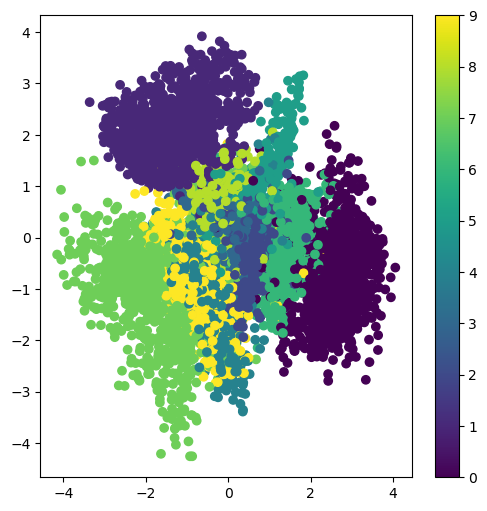

In [11]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()

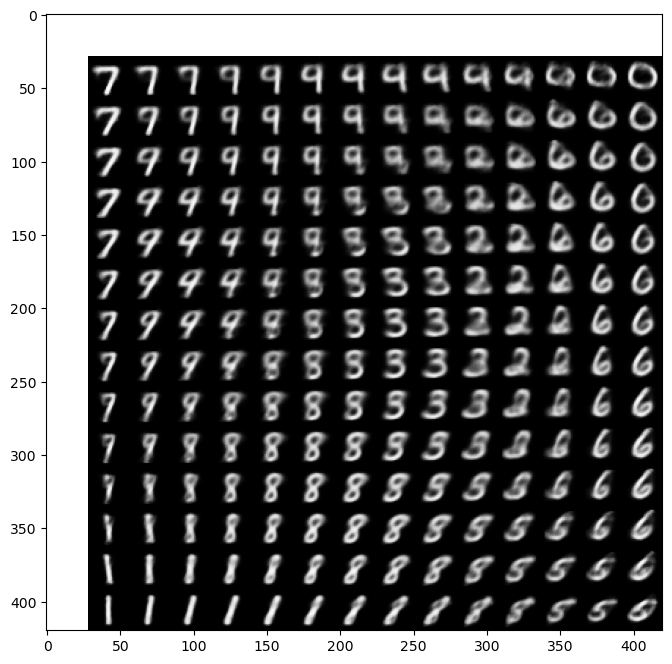

In [12]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(-0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(-0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_smaple = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_smaple)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
              j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(8,8))
plt.imshow(figure, cmap='Greys_r')

## Source Code

## Reference

Paper : https://arxiv.org/pdf/1406.2661v1.pdf